## Tutorial 5: Quantum Neural Network
#### Julien Rauch, January 2026

### 1 - Introduction
This time, we will use our quantum circuit (feature map) directly as a quantum neural network inserted in an optimization loop:

- Each input data vector is embedded into Hilbert space by the feature map of $n$ qubits with a set of parameters $\theta$ and produces an output quantum state of $n$ qubits. This is then measured to produce an output data vector of $2^n$ values (probabilities), that corresponds to the projection of $\ket{\phi_{\theta}(x)} = U(x, \theta)\ket{0}^n$.

- The CPU then clusters the data based on projections of the quantum states of each input data point. This clustering is evaluated using an NMI metric based on the known labels for each input data point. Finally, a Cobyla optimizer experiments with new sets of parameters $\theta$ to obtain new embeddings, then new clusters, and ultimately achieve a better NMI metric.

### 2 - Quantum Circuit Design: Feature Map as QNN

We will create a circuit consisting of the embedding section from the previous tutorial, and we will add a parametric section consisting of $Ry$ gates and $controled~Rz$ gates connected circularly (inspired of EfficientSU2 feature map). 

Here is the circuit in question for a single layer:

![image](./img/circuit_var.png)

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

In [2]:
def embbeding_parametric_circuit(nb_qubit, nb_feature, name_param="parameters", name_input="input", nb_layer=1):
    """
        nb_qubit : number of qubits in the circuit
        nb_feature : number of features of a data vector
        name_param : name will be the identifier of the ParameterVector corresponding to the parameters
        name_input : name will be the identifier of the ParameterVector corresponding to the input
        nb_layer : number of layers in the circuit
        This function returns the embedding and variational circuit.
    """
    #TODO create the embedding circuit

    # Create parameter vectors for inputs and parameters
    input_params = ParameterVector(name_input, nb_feature)
    param_params = ParameterVector(name_param, nb_layer * nb_qubit * 2)
    circuit = QuantumCircuit(nb_qubit)

    if nb_qubit>1:
        for layer in range(nb_layer):
            circuit.h(range(nb_qubit))
            for i in range(nb_qubit):
                circuit.rz(input_params[i % nb_feature], i)
                circuit.ry(param_params[i], i)
            for i in range(nb_qubit):
                circuit.cx(i, (i + 1) % nb_qubit)
                circuit.rz(param_params[nb_qubit + i], (i + 1) % nb_qubit)
                circuit.cx(i, (i + 1) % nb_qubit)
                

    else:
        for layer in range(nb_layer):
            circuit.h(range(nb_qubit))
            for i in range(nb_qubit):
                circuit.rz(input_params[i % nb_feature], i)
                circuit.ry(param_params[i], i)

    return circuit

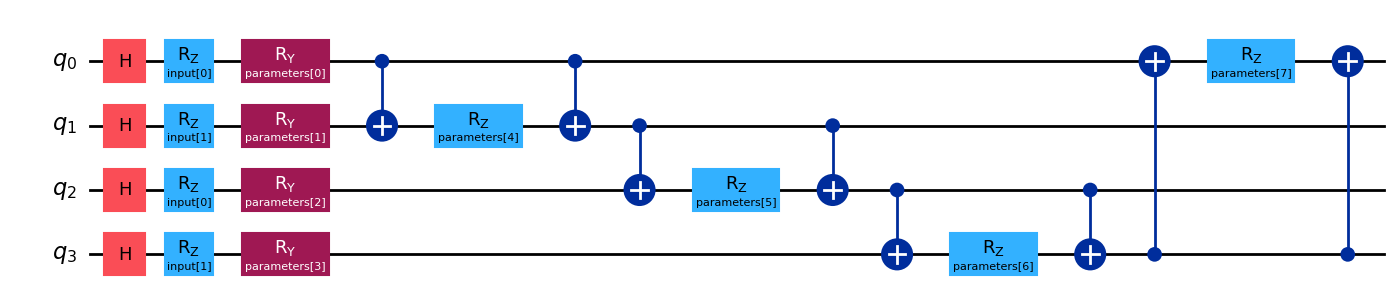

In [3]:
# Print the circuit
embbeding_parametric_circuit(4,2).draw('mpl') # Basic printing, you can improve

### 3 - Global Data Embedding Function

We need a function that acheving the **data embedding loop**:

- Successively load the input data vectors with fixed parameters $\theta$ defined in the quantum circuit, then store and return the projections of the output quantum states.

In [4]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

nb_shots = 2000 #1024 by default
sim = AerSimulator(shots=nb_shots)

# create the pass manager (managing and optimizing the quantum circuit)
pm = generate_preset_pass_manager(backend=sim, optimization_level=1)

In [10]:
# Data embedding loop function
def embedding_data(nb_qubit, nb_feature, dataset, parameters, backend, pass_manager, nb_layer=1):
    """
        nb_qubit : number of qubits in the circuit
        nb_feature : number of features of a data vector
        dataset : data to embedded
        parameters : parameters of the variational circuit
        backend : backend to run the circuit
        pass_manager : pass manager to transpose the circuit by adapting it to the backend
        nb_layer : number of layers in the circuit
        This function returns the embedded data
    """
    res = []       # list of output quantum state projection
    n=len(dataset) # number of projections
    m=len(parameters) # number of parameters

    #TODO
    sampler = Sampler(mode=backend)
    qc = embbeding_parametric_circuit(nb_qubit, nb_feature, nb_layer=nb_layer)
    qc.measure_all()
    transpiled_qc = pass_manager.run(qc)

    circuits = []
    for i in range(n):
        for j in range(i+1, n):
            param_dict = {f"input[{k}]": dataset[i][k] for k in range(nb_feature)}
            param_dict.update({f"parameters[{l}]": parameters[l] for l in range(m)})
            qc = transpiled_qc.assign_parameters(param_dict)
            circuits.append(qc)

    sampler = Sampler(backend)
    job = sampler.run(circuits, shots=nb_shots)
    results = job.result()

    k = 0
    res = []
    for i in range(n):
        for j in range(i+1, n):
            result = results[k]
            count_data = result.data.meas.get_counts()

            prob_vector = np.zeros(2**nb_qubit)
            total_shots = sum(count_data.values())
                
            for bitstring, count in count_data.items():
                # Convert bitstring (e.g. '01') to integer index (e.g. 1)
                index = int(bitstring, 2)
                # Calculate probability
                prob_vector[index] = count / total_shots
            res.append(prob_vector)
            k += 1
            

    return res
    

In [11]:
# Execution of the data embedding loop on a small dataset with random theta parameters
embedding_data(1, 1, [[0.2], [0.8], [3.4]], np.random.random(1), sim, pm)

AttributeError: 'str' object has no attribute 'values'

### 4 - Data Clustering using outputs of the Quantum Neural Network

In this section, we aim to perform a data clustering using the projections provided by our previous parametric circuit (QNN) with random parameters.

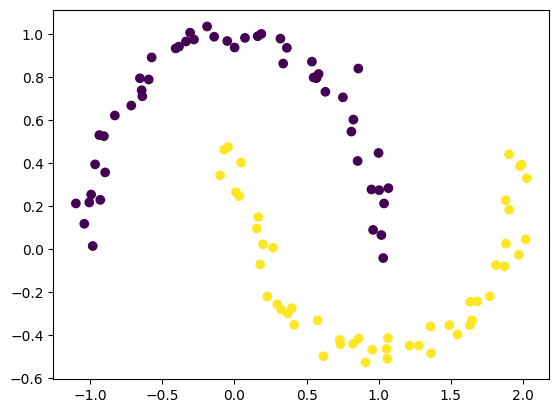

In [7]:
from sklearn.datasets import make_moons
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

# Importing the "moons" dataset and the associated labels
X_moons, y_moons = make_moons(100, noise=0.05)
plt.scatter(X_moons[:,0], X_moons[:,1], c=y_moons)

Do the clustering like in the previous tutorial (for the parameters uses ```np.random.random``` for now).

In [9]:
# TODO Do the preprocessing
X_moons = preprocessing.MinMaxScaler((0, np.pi)).fit_transform(X_moons)


# TODO Call your data embedding function and run a spectral clustering (With calculation of the affinity matrix on the fly)
embedded_data = embedding_data(2, 2, X_moons, np.random.random(4), sim, pm, nb_layer=2)

print(np.shape(np.array(embedded_data)))


# TODO Compute and print the NMI result
clustering = SpectralClustering(2, affinity="precomputed")
# affinity_matrix = np.exp(-np.array(embedded_data).reshape(100, 100))
labels = clustering.fit_predict(embedded_data)
nmi = normalized_mutual_info_score(y_moons, labels)


# TODO Display the dataset with computed labeling
plt.figure()
plt.scatter(X_moons[:,0], X_moons[:,1], c=labels)
print("Normalized Mutual Information (NMI):", nmi)


(4950, 4)


ValueError: array must be 2-dimensional and square. shape = (4950, 4)

## 5 - Complete classification algorithm:
### - Use of previous data clustering 
### - Optimization of embedding performed by QNN

This section is devoted to the implementation and experimentation of the complete ML algorithm in order to obtain optimal classification.

### 5.1 - Display Function

In [ ]:
from IPython.display import clear_output
from scipy.optimize import minimize

score_evolution = []

#This function will display the result of our classification and the evolution of the score (NMI) at each loop (epoch).
def plot_training_progress(cluster_labels_save):

    if len(score_evolution) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # NMI
    ax1.set_title("Classification Score")
    ax1.plot(score_evolution)
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("NMI")

    # Labeling
    ax2.set_title("Labeling")
    ax2.scatter(X_moons[:,0], X_moons[:,1], c=cluster_labels_save)

    plt.show()

### 5.2 - Design of the objective function

To optimize the classification we first design an "objective function" that takes as parameters those that must be supplied to our circuit ($\theta$ parameters) and returns a score that we want to minimize, we will use the ```minimize``` function from the ```scipy.optimize``` module. 
This objective function will be used at the next section.

In [ ]:
def f_objective(parameter):
    # TODO: call your data embedding function, run a spectral clustering providing the cluster labels 
    # and compute the NMI result (nmi)


    # We store the NMI score in the global score list and call the previously defined plot_training_progress function, 
    # which will display the progress of our training
    score_evolution.append(nmi)
    plot_training_progress(cluster_labels)

    # TODO return the score to minimize 
    return

### 5.3 - Run the learning loop

Use the ```minimize``` function from the ```scipy.optimize``` module on the previous objective function.

In [ ]:
# We initialize the score list to store the evolution of the NMI.
score_evolution = []

#TODO Initialize the parameters
# x0 = ...

#TODO Run minimize function (method='COBYLA') and stock the result in a variable
# res = ...

Display the final result

In [ ]:
# TODO: call your data embedding function and run a spectral clustering with the optimized parameters
#embedded_data = ...


# TODO Compute and print the NMI result


# TODO Display the dataset with computed labeling
